In [37]:
# !pip install seaborn
# !pip install wordcloud
# !pip install plotly 
# !pip install textstat
# !pip install nltk

# Imports

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import string

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Inital Exploration

In [5]:
export_dir = Path(os.getcwd()).parent
data_path = Path(export_dir, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
df = pd.read_csv(Path(data_path, "phishing_email.csv"))
# df = pd.read_csv(Path(data_path, "CEAS_08.csv"))

In [7]:
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [8]:
print(f"The df shpe is: {df.shape}")
print("Some more infornation:")
print(df.info())

The df shpe is: (82486, 2)
Some more infornation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None


## Look at a specific row for better understanding 

In [9]:
num_row = 76001
print(df['label'].iloc[num_row])
print(df['text_combined'].iloc[num_row])

1
ein news peeuropeaninternetcom dear sirmadam name petr stanek managing iraq today news service wwweuropeaninternetcomiraq iraq today contains hourly updated breaking news headlines exchange rates market news important information associates free trial subscription iraq today access collection 25000 daily updated articles news archive many benefits trial free subscribe reply email sign httpwwweuropeaninternetcomloginaffiliate_registerphp3 partial list current ein subscribers found httpwwweuropeaninternetcommediakit questions comments need assistance signing please contact us personally either writing helpdeskeuropeaninternetcom simply replying email please feel free forward offer colleagues best regards petr stanek subscription department ein news removed please reply removeeuropeaninternetcom wed 28 aug 2002 155844 0200 cest iraq today daily news free trial


# Data exploratrion

## Label Distribution

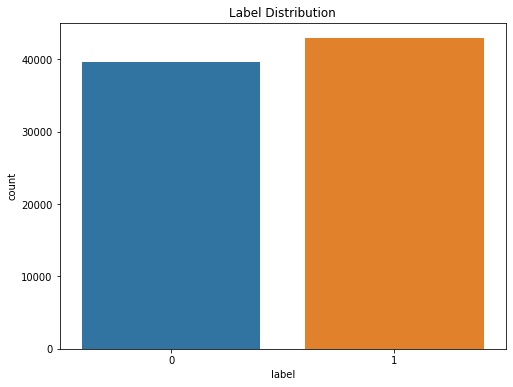

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

## Text length features

In [11]:
# Text Length Features
df['char_count'] = df['text_combined'].apply(len)
df['text_length'] = df['text_combined'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['text_combined'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
print(df['text_length'].describe())

count     82486.000000
mean        160.627222
std         543.720722
min           0.000000
25%          39.000000
50%          79.000000
75%         183.000000
max      107710.000000
Name: text_length, dtype: float64


## Text Length Distribution

In [22]:
filter = 1000 # 98% of the data is in these values

In [23]:
df[df['text_length'] > filter].shape

(1078, 6)

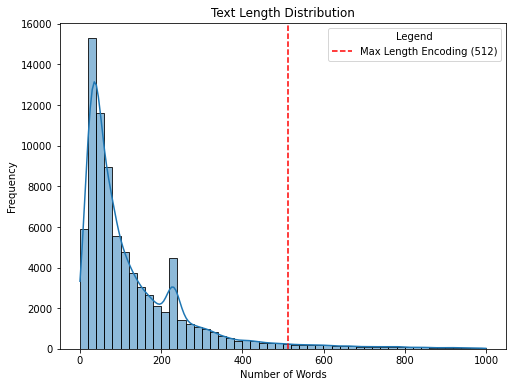

In [36]:
plt.figure(figsize=(8, 6))

# Plotting the histogram with hue and kde
sns.histplot(df[df['text_length'] < filter], x='text_length', bins=50, kde=True)

# Adding the red dashed line at x=512
plt.axvline(x=512, color='red', linestyle='--', label='Max Length Encoding (512)')

plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Updating the legend to include both hue categories and the red line label
plt.legend(title='Legend')

plt.savefig('text_length_distribution.jpg', dpi=1000, bbox_inches='tight')

plt.show()

# Word cloud

In [40]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Ensure that the dataset has the correct columns
# Columns: 'text_combined' (email content) and 'label' (0 for non-phishing, 1 for phishing)
assert 'text_combined' in df.columns and 'label' in df.columns, "Dataset must contain 'text_combined' and 'label' columns."


In [41]:
# Separate phishing and non-phishing emails
phishing_emails = df[df['label'] == 1]['text_combined']
non_phishing_emails = df[df['label'] == 0]['text_combined']

# Combine all phishing and non-phishing emails into single text for each category
phishing_text = ' '.join(phishing_emails)
non_phishing_text = ' '.join(non_phishing_emails)



In [43]:
# Generate word clouds without specifying a font path
wordcloud_phishing = WordCloud(width=800, height=400, background_color='white').generate(phishing_text)
wordcloud_non_phishing = WordCloud(width=800, height=400, background_color='white').generate(non_phishing_text)

ValueError: Only supported for TrueType fonts

In [ ]:
# Plotting the word clouds
plt.figure(figsize=(15, 8))

# Phishing emails word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_phishing, interpolation='bilinear')
plt.title('Phishing Emails', fontsize=20)
plt.axis('off')

# Non-Phishing emails word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_phishing, interpolation='bilinear')
plt.title('Non-Phishing Emails', fontsize=20)
plt.axis('off')

plt.tight_layout()
plt.show()


## Linguistic Features

In [30]:
df['uppercase_count'] = df['text_combined'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['exclamation_count'] = df['text_combined'].apply(lambda x: x.count('!'))
df['question_count'] = df['text_combined'].apply(lambda x: x.count('?'))
df['special_char_count'] = df['text_combined'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [37]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Text analysis

We expect to see a lot of upper case letters an especially in the phishing E-mails.

In [31]:
def uppercase_proportion(text):
    total_chars = len(text)
    uppercase_chars = sum(1 for c in text if c.isupper())
    return uppercase_chars / total_chars if total_chars > 0 else 0

In [32]:
df['uppercase_proportion'] = df['text_combined'].apply(uppercase_proportion)

In [33]:
df[df['uppercase_proportion'] > 0]

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion
57883,john dlugosz dhcgnd702sneakemailcom tsa thomas...,0,1126,178,5.331461,4,0,0,0,0.003552
58229,xavier noria fxnhashrefcom thu aug 7 2008 319 ...,0,455,69,5.608696,1,0,0,0,0.002198
81618,utf8bummrevdjkukgwqk yymkpcmircgryad95ofmcxjz6...,1,800,87,8.206897,6,0,0,11,0.007500
81663,apple crendhyjembudorg 𝖯𝗈𝗅𝗂𝖼𝗒 𝖵𝗂𝗈𝗅𝖺𝗍𝗂𝗈𝗇 𝖨𝗆𝗆𝖾𝖽𝗂...,1,1665,265,5.286792,74,0,0,0,0.044444


### !

In [50]:
df[df['uppercase_count'] > 0]

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion
57883,john dlugosz dhcgnd702sneakemailcom tsa thomas...,0,1126,178,5.331461,4,0,0,0,0.003552
58229,xavier noria fxnhashrefcom thu aug 7 2008 319 ...,0,455,69,5.608696,1,0,0,0,0.002198
81618,utf8bummrevdjkukgwqk yymkpcmircgryad95ofmcxjz6...,1,800,87,8.206897,6,0,0,11,0.007500
81663,apple crendhyjembudorg 𝖯𝗈𝗅𝗂𝖼𝗒 𝖵𝗂𝗈𝗅𝖺𝗍𝗂𝗈𝗇 𝖨𝗆𝗆𝖾𝖽𝗂...,1,1665,265,5.286792,74,0,0,0,0.044444


### ?

In [51]:
df[df['exclamation_count'] > 0]

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion


### special

In [52]:
df[df['special_char_count'] > 0]

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion
44,gisb contracts intrastate interstate gas mr fa...,0,1647,261,5.314176,0,0,0,1,0.0
336,enron actuals july 14 thru 16 2000 revised ami...,0,830,172,3.831395,0,0,0,2,0.0
429,revision 1 enron actuals may 11 2000 correct n...,0,460,89,4.179775,0,0,0,2,0.0
433,revision 1 enron actuals may 18 2000 teco tap ...,0,502,103,3.883495,0,0,0,2,0.0
577,unify gas month end close november 2001 please...,0,1536,245,5.273469,0,0,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...
82478,netlflx cool390rnatlikadeliycom dear customer ...,1,366,37,8.918919,0,0,0,2,0.0
82479,wetransfer no_replywetransfercom test transfer...,1,820,97,7.463918,0,0,0,1,0.0
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,6.294118,0,0,0,34,0.0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,7.787037,0,0,0,2,0.0


## Calculate word frequency for phishing and non-phishing emails without converting to lowercase

In [ ]:
# phishing_tokens = df[df['label'] == 1]['tokens'].sum()
# non_phishing_tokens = df[df['label'] == 0]['tokens'].sum()

# phishing_word_freq = Counter(phishing_tokens)
# non_phishing_word_freq = Counter(non_phishing_tokens)

In [ ]:
# # Display the most common words
# phishing_common_words = pd.DataFrame(phishing_word_freq.most_common(20), columns=['word', 'count'])
# non_phishing_common_words = pd.DataFrame(non_phishing_word_freq.most_common(20), columns=['word', 'count'])

# print("Most common words in phishing emails:")
# print(phishing_common_words)

# print("Most common words in non-phishing emails:")
# print(non_phishing_common_words)

In [ ]:
# phishing_common_words.to_csv('phishing_common_words.csv', index=False)
# non_phishing_common_words.to_csv('non_phishing_common_words.csv', index=False)

## Sentiment Analysisfrom

In [53]:
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['text_combined'].apply(lambda x: sid.polarity_scores(x)['compound'])

## Readability Scores

In [34]:
df['flesch_reading_ease'] = df['text_combined'].apply(flesch_reading_ease)
df['flesch_kincaid_grade'] = df['text_combined'].apply(flesch_kincaid_grade)

### Tokenize

In [ ]:
# Tokenize the text and remove stopwords
df['tokens'] = df['text_combined'].apply(lambda x: [word for word in nltk.word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

In [ ]:
df['token_length'] = df['tokens'].apply(lambda x: len(x))

In [ ]:
df[df['token_length'] == df['text_length']].shape

## Example of extracting TF-IDF features

In [41]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['text_combined'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

In [45]:
df

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion,...,using,virus,want,way,web,wed,well,work,would,wrote
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,3.714286,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,4.153846,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,4.321429,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,3.714286,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,3.714286,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,6.294118,0,0,0,34,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,7.590909,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,7.787037,0,0,0,2,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,6.540000,0,0,0,0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## List of spam-related words

In [46]:
spam_words = ['free', 'win', 'winner', 'prize', 'cash', 'urgent', 'limited', 'act now', 'buy', 'cheap', 
              'discount', 'offer', 'credit', 'congratulations', 'risk-free', 'guarantee', 'save', 'order now', 
              'deal', 'click', 'subscribe', 'bonus']

# Add individual counts for each spam-related word
for word in spam_words:
    df[f'{word}_count'] = df['text_combined'].apply(lambda x: x.lower().split().count(word))

# Calculate correlation of each spam word count with the label
correlation = df[[f'{word}_count' for word in spam_words] + ['label']].corr()['label'].drop('label')

# Select words with positive correlation
positive_spam_words = correlation[correlation > 0].index

# Aggregate counts of positively correlated spam words
df['positive_spam_word_count'] = df[positive_spam_words].sum(axis=1)

In [47]:
# Print the correlation of spam words to the label
print(f'Words with positive correlation to label: {list(positive_spam_words)}')
print(df[['text_combined', 'label', 'positive_spam_word_count', 'sentiment']].head())

Words with positive correlation to label: ['free_count', 'win_count', 'winner_count', 'prize_count', 'cash_count', 'urgent_count', 'buy_count', 'cheap_count', 'discount_count', 'offer_count', 'congratulations_count', 'guarantee_count', 'save_count', 'click_count', 'bonus_count']
                                       text_combined  label  \
0  hpl nom may 25 2001 see attached file hplno 52...      0   
1  nom actual vols 24 th forwarded sabrae zajac h...      0   
2  enron actuals march 30 april 1 201 estimated a...      0   
3  hpl nom may 30 2001 see attached file hplno 53...      0   
4  hpl nom june 1 2001 see attached file hplno 60...      0   

   positive_spam_word_count  sentiment  
0                         0     0.0000  
1                         0     0.9313  
2                         0     0.0000  
3                         0     0.0000  
4                         0     0.0000  


In [52]:
#check how many columns are there:
spam_columns = [f'{word}_count' for word in spam_words]

non_zero_counts = {}

# Iterate over the columns and count non-zero values
for column in spam_columns:
    non_zero_counts[column] = (df[column] != 0).sum()

for column, count in non_zero_counts.items():
    print(f'{column}: {count} non-zero values')

free_count: 8483 non-zero values
win_count: 819 non-zero values
winner_count: 415 non-zero values
prize_count: 451 non-zero values
cash_count: 2211 non-zero values
urgent_count: 2024 non-zero values
limited_count: 3044 non-zero values
act now_count: 0 non-zero values
buy_count: 3417 non-zero values
cheap_count: 1324 non-zero values
discount_count: 703 non-zero values
offer_count: 5823 non-zero values
credit_count: 2498 non-zero values
congratulations_count: 613 non-zero values
risk-free_count: 0 non-zero values
guarantee_count: 1366 non-zero values
save_count: 4392 non-zero values
order now_count: 0 non-zero values
deal_count: 6002 non-zero values
click_count: 8206 non-zero values
subscribe_count: 960 non-zero values
bonus_count: 551 non-zero values


In [53]:
df

,text_combined,label,char_count,text_length,avg_word_length,uppercase_count,exclamation_count,question_count,special_char_count,uppercase_proportion,...,congratulations_count,risk-free_count,guarantee_count,save_count,order now_count,deal_count,click_count,subscribe_count,bonus_count,positive_spam_word_count
0,hpl nom may 25 2001 see attached file hplno 52...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0,1071,208,4.153846,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,enron actuals march 30 april 1 201 estimated a...,0,148,28,4.321429,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,hpl nom may 30 2001 see attached file hplno 53...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,hpl nom june 1 2001 see attached file hplno 60...,0,65,14,3.714286,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1,1735,238,6.294118,0,0,0,34,0.0,...,0,0,0,0,0,0,2,0,0,2
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1,188,22,7.590909,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
82483,help center infohelpcentercoza_infohelpcenterc...,1,948,108,7.787037,0,0,0,2,0.0,...,0,0,0,0,0,0,0,0,0,0
82484,metamask infosofamekarcom verify metamask wall...,1,376,50,6.540000,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
